Here we will use 24 hour averages instead: we want to predict general trends of the air pollution

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

ds = xr.open_dataset("era5_all_16_3_50_8.nc")
ds['t2m_celsius'] = ds['t2m'] - 273.15
ds['d2m_celsius'] = ds['d2m'] - 273.15

In [2]:
from read_data import read_data
df_merged, df_avg = read_data("PM10_24g")

Wczytywanie: .\2000\2000_PM10_24g.xlsx
Wczytywanie: .\2001\2001_PM10_24g.xlsx
Wczytywanie: .\2002\2002_PM10_24g.xlsx
Wczytywanie: .\2003\2003_PM10_24g.xlsx
Wczytywanie: .\2004\2004_PM10_24g.xlsx
Wczytywanie: .\2005\2005_PM10_24g.xlsx
Wczytywanie: .\2006\2006_PM10_24g.xlsx
Wczytywanie: .\2007\2007_PM10_24g.xlsx
Wczytywanie: .\2008\2008_PM10_24g.xlsx
Wczytywanie: .\2009\2009_PM10_24g.xlsx
Wczytywanie: .\2010\2010_PM10_24g.xlsx
Wczytywanie: .\2011\2011_PM10_24g.xlsx
Wczytywanie: .\2012\2012_PM10_24g.xlsx
Wczytywanie: .\2013\2013_PM10_24g.xlsx
Wczytywanie: .\2014\2014_PM10_24g.xlsx
Wczytywanie: .\2015\2015_PM10_24g.xlsx
Wczytywanie: .\2016\2016_PM10_24g.xlsx
Wczytywanie: .\2017\2017_PM10_24g.xlsx
Wczytywanie: .\2018\2018_PM10_24g.xlsx
Wczytywanie: .\2019\2019_PM10_24g.xlsx
Wczytywanie: .\2020\2020_PM10_24g.xlsx
Wczytywanie: .\2021\2021_PM10_24g.xlsx
Wczytywanie: .\2022\2022_PM10_24g.xlsx
Wczytywanie: .\2023\2023_PM10_24g.xlsx
            DsWrocWie  KpCiechTezni  LdLodzWSSEMWodna40  MpKrakA

d:\MOJE\ERA5+MLwalbrzych\read_data.py:105: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_merged = df_renamed.groupby(axis=1, level=0).mean(numeric_only=True)


In [3]:
data_wal = df_merged["DsWalbrzWyso"]
data_wal = data_wal[data_wal.index.year > 2014]

Let's prepare the data for our machine learning

In [6]:

df_meteo = ds.to_dataframe().reset_index()
df_meteo = df_meteo.set_index('valid_time')
df_meteo.index = pd.to_datetime(df_meteo.index)
df_meteo = df_meteo[df_meteo.index >= '2015-01-01']

data_wal.index = pd.to_datetime(data_wal.index)
df_pm10 = data_wal.rename("pm10")  
df_full = df_meteo.join(df_pm10, how='inner')

df_full['wind_speed'] = np.sqrt(df_full['u10']**2 + df_full['v10']**2)
df_full['month'] = df_full.index.month
df_full['weekday'] = df_full.index.weekday


# Lag features (co było w przeszłości)
for lag in [1,2,3]:
    #Let's assume that we want to predict PM10 concentration based only on the weather data
    #df_full[f'pm10_lag{lag}'] = df_full['pm10'].shift(lag)
    df_full[f'u10_lag{lag}'] = df_full['u10'].shift(lag)
    df_full[f'v10_lag{lag}'] = df_full['v10'].shift(lag)
    df_full[f'tp_lag{lag}'] = df_full['u10'].shift(lag)
    df_full[f'sp_lag{lag}'] = df_full['u10'].shift(lag)
    df_full[f't2m_celsius_lag{lag}'] = df_full['u10'].shift(lag)
    df_full[f'd2m_celsius_lag{lag}'] = df_full['u10'].shift(lag)
    df_full[f'wind_speed_lag{lag}'] = df_full['wind_speed'].shift(lag)
    

df_full = df_full.dropna()

df_full = df_full.drop(['latitude', 'longitude', 'd2m', 't2m', 'ssrd'], axis = 1)
df_full.to_csv("wal_full_data24h")
df_full

,sp,tp,snowc,u10,v10,t2m_celsius,d2m_celsius,pm10,wind_speed,month,...,t2m_celsius_lag2,d2m_celsius_lag2,wind_speed_lag2,u10_lag3,v10_lag3,tp_lag3,sp_lag3,t2m_celsius_lag3,d2m_celsius_lag3,wind_speed_lag3
2015-01-04,95857.789062,1.079440e-04,16.947266,4.582253,-1.089879,0.024261,-2.360687,13.1,4.710082,1,...,2.294790,2.294790,4.130163,2.394073,0.907806,2.394073,2.394073,2.394073,2.394073,2.560410
2015-01-05,97220.093750,9.834766e-07,27.585938,4.216387,-3.428027,-2.257263,-4.404785,10.2,5.434086,1,...,6.290475,6.290475,6.304680,2.294790,3.433975,2.294790,2.294790,2.294790,2.294790,4.130163
2015-01-06,97289.390625,1.460314e-06,74.681641,1.889061,-1.831711,-2.972382,-3.556946,66.4,2.631295,1,...,4.582253,4.582253,4.710082,6.290475,-0.422989,6.290475,6.290475,6.290475,6.290475,6.304680
2015-01-07,97366.867188,1.498847e-09,75.058594,-0.093872,2.593323,-8.916534,-10.987579,30.0,2.595021,1,...,4.216387,4.216387,5.434086,4.582253,-1.089879,4.582253,4.582253,4.582253,4.582253,4.710082
2015-01-08,97464.484375,1.384644e-06,82.574219,1.079422,1.906357,-2.377899,-3.483063,22.2,2.190741,1,...,1.889061,1.889061,2.631295,4.216387,-3.428027,4.216387,4.216387,4.216387,4.216387,5.434086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,96529.937500,2.565980e-05,0.093750,5.431082,-0.981384,4.563660,0.853058,7.8,5.519037,12,...,6.776779,6.776779,7.043875,3.044113,-0.053375,3.044113,3.044113,3.044113,3.044113,3.044581
2023-12-28,96447.875000,0.000000e+00,0.082031,2.041260,4.133255,3.375763,0.877899,12.4,4.609830,12,...,3.559189,3.559189,4.214143,6.776779,1.921310,6.776779,6.776779,6.776779,6.776779,7.043875
2023-12-29,96216.398438,0.000000e+00,0.048828,2.751968,2.979156,4.675262,3.309143,12.5,4.055700,12,...,5.431082,5.431082,5.519037,3.559189,2.256363,3.559189,3.559189,3.559189,3.559189,4.214143
2023-12-30,95789.687500,0.000000e+00,0.007812,4.298935,3.594406,6.009552,2.643890,12.6,5.603623,12,...,2.041260,2.041260,4.609830,5.431082,-0.981384,5.431082,5.431082,5.431082,5.431082,5.519037


In [8]:
df_ml = df_full.copy()
X = df_ml.drop(columns=['pm10'])
y = df_ml['pm10']
X

,sp,tp,snowc,u10,v10,t2m_celsius,d2m_celsius,wind_speed,month,weekday,...,t2m_celsius_lag2,d2m_celsius_lag2,wind_speed_lag2,u10_lag3,v10_lag3,tp_lag3,sp_lag3,t2m_celsius_lag3,d2m_celsius_lag3,wind_speed_lag3
2015-01-04,95857.789062,1.079440e-04,16.947266,4.582253,-1.089879,0.024261,-2.360687,4.710082,1,6,...,2.294790,2.294790,4.130163,2.394073,0.907806,2.394073,2.394073,2.394073,2.394073,2.560410
2015-01-05,97220.093750,9.834766e-07,27.585938,4.216387,-3.428027,-2.257263,-4.404785,5.434086,1,0,...,6.290475,6.290475,6.304680,2.294790,3.433975,2.294790,2.294790,2.294790,2.294790,4.130163
2015-01-06,97289.390625,1.460314e-06,74.681641,1.889061,-1.831711,-2.972382,-3.556946,2.631295,1,1,...,4.582253,4.582253,4.710082,6.290475,-0.422989,6.290475,6.290475,6.290475,6.290475,6.304680
2015-01-07,97366.867188,1.498847e-09,75.058594,-0.093872,2.593323,-8.916534,-10.987579,2.595021,1,2,...,4.216387,4.216387,5.434086,4.582253,-1.089879,4.582253,4.582253,4.582253,4.582253,4.710082
2015-01-08,97464.484375,1.384644e-06,82.574219,1.079422,1.906357,-2.377899,-3.483063,2.190741,1,3,...,1.889061,1.889061,2.631295,4.216387,-3.428027,4.216387,4.216387,4.216387,4.216387,5.434086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,96529.937500,2.565980e-05,0.093750,5.431082,-0.981384,4.563660,0.853058,5.519037,12,2,...,6.776779,6.776779,7.043875,3.044113,-0.053375,3.044113,3.044113,3.044113,3.044113,3.044581
2023-12-28,96447.875000,0.000000e+00,0.082031,2.041260,4.133255,3.375763,0.877899,4.609830,12,3,...,3.559189,3.559189,4.214143,6.776779,1.921310,6.776779,6.776779,6.776779,6.776779,7.043875
2023-12-29,96216.398438,0.000000e+00,0.048828,2.751968,2.979156,4.675262,3.309143,4.055700,12,4,...,5.431082,5.431082,5.519037,3.559189,2.256363,3.559189,3.559189,3.559189,3.559189,4.214143
2023-12-30,95789.687500,0.000000e+00,0.007812,4.298935,3.594406,6.009552,2.643890,5.603623,12,5,...,2.041260,2.041260,4.609830,5.431082,-0.981384,5.431082,5.431082,5.431082,5.431082,5.519037


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
y_pred = model.predict(X_test)

# Metryki
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² score: {r2:.2f}")

RMSE: 12.67
R² score: 0.47


We see that the prediction is not so good, probably we have just too many parameters

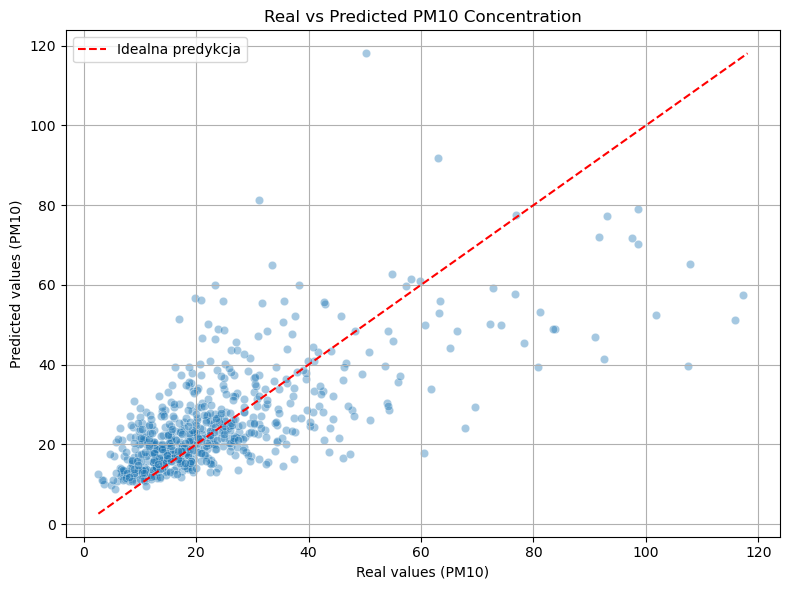

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tworzymy wykres scatter z linią idealnej predykcji
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)

# Linia idealna: predykcja == rzeczywistość
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Idealna predykcja')

plt.xlabel("Real values (PM10)")
plt.ylabel("Predicted values (PM10)")
plt.title("Real vs Predicted PM10 Concentration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

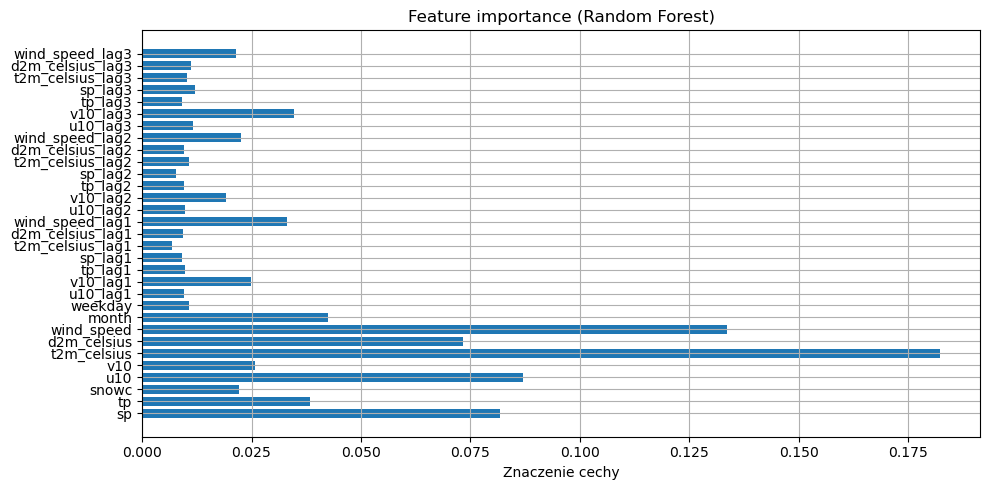

In [13]:
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,5))
plt.barh(feature_names, importances)
plt.xlabel('Znaczenie cechy')
plt.title('Feature importance (Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.show()

Let's try to decrease the number of parameters:

In [16]:
X = df_ml.drop(columns=['pm10', 'd2m_celsius_lag2', 'u10_lag2', 'v10_lag2', 't2m_celsius_lag2', 'wind_speed_lag2', 'sp_lag2', 'tp_lag2',
                    'd2m_celsius_lag3', 'u10_lag3', 'v10_lag3', 't2m_celsius_lag3', 'wind_speed_lag3', 'sp_lag3', 'tp_lag3', ])
y = df_ml['pm10']
X

,sp,tp,snowc,u10,v10,t2m_celsius,d2m_celsius,wind_speed,month,weekday,u10_lag1,v10_lag1,tp_lag1,sp_lag1,t2m_celsius_lag1,d2m_celsius_lag1,wind_speed_lag1
2015-01-04,95857.789062,1.079440e-04,16.947266,4.582253,-1.089879,0.024261,-2.360687,4.710082,1,6,6.290475,-0.422989,6.290475,6.290475,6.290475,6.290475,6.304680
2015-01-05,97220.093750,9.834766e-07,27.585938,4.216387,-3.428027,-2.257263,-4.404785,5.434086,1,0,4.582253,-1.089879,4.582253,4.582253,4.582253,4.582253,4.710082
2015-01-06,97289.390625,1.460314e-06,74.681641,1.889061,-1.831711,-2.972382,-3.556946,2.631295,1,1,4.216387,-3.428027,4.216387,4.216387,4.216387,4.216387,5.434086
2015-01-07,97366.867188,1.498847e-09,75.058594,-0.093872,2.593323,-8.916534,-10.987579,2.595021,1,2,1.889061,-1.831711,1.889061,1.889061,1.889061,1.889061,2.631295
2015-01-08,97464.484375,1.384644e-06,82.574219,1.079422,1.906357,-2.377899,-3.483063,2.190741,1,3,-0.093872,2.593323,-0.093872,-0.093872,-0.093872,-0.093872,2.595021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,96529.937500,2.565980e-05,0.093750,5.431082,-0.981384,4.563660,0.853058,5.519037,12,2,3.559189,2.256363,3.559189,3.559189,3.559189,3.559189,4.214143
2023-12-28,96447.875000,0.000000e+00,0.082031,2.041260,4.133255,3.375763,0.877899,4.609830,12,3,5.431082,-0.981384,5.431082,5.431082,5.431082,5.431082,5.519037
2023-12-29,96216.398438,0.000000e+00,0.048828,2.751968,2.979156,4.675262,3.309143,4.055700,12,4,2.041260,4.133255,2.041260,2.041260,2.041260,2.041260,4.609830
2023-12-30,95789.687500,0.000000e+00,0.007812,4.298935,3.594406,6.009552,2.643890,5.603623,12,5,2.751968,2.979156,2.751968,2.751968,2.751968,2.751968,4.055700


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
y_pred = model.predict(X_test)

# Metryki
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² score: {r2:.2f}")

RMSE: 12.23
R² score: 0.51


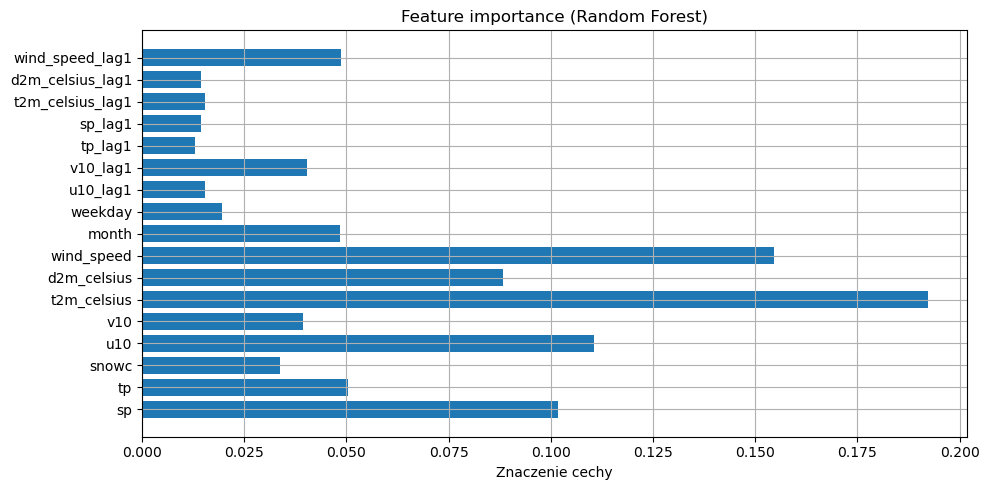

In [19]:
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,5))
plt.barh(feature_names, importances)
plt.xlabel('Znaczenie cechy')
plt.title('Feature importance (Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.show()

This time we performed better, but it is still far from perfect

In [20]:
X = df_ml.drop(columns=['pm10', 'd2m_celsius_lag2', 'u10_lag2', 'v10_lag2', 't2m_celsius_lag2', 'wind_speed_lag2', 'sp_lag2', 'tp_lag2',
                    'd2m_celsius_lag3', 'u10_lag3', 'v10_lag3', 't2m_celsius_lag3', 'wind_speed_lag3', 'sp_lag3', 'tp_lag3', 
                    'd2m_celsius_lag1', 'u10_lag1', 'v10_lag1', 't2m_celsius_lag1', 'sp_lag1', 'tp_lag1',])
y = df_ml['pm10']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [21]:
y_pred = model.predict(X_test)

# Metryki
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² score: {r2:.2f}")

RMSE: 12.25
R² score: 0.51


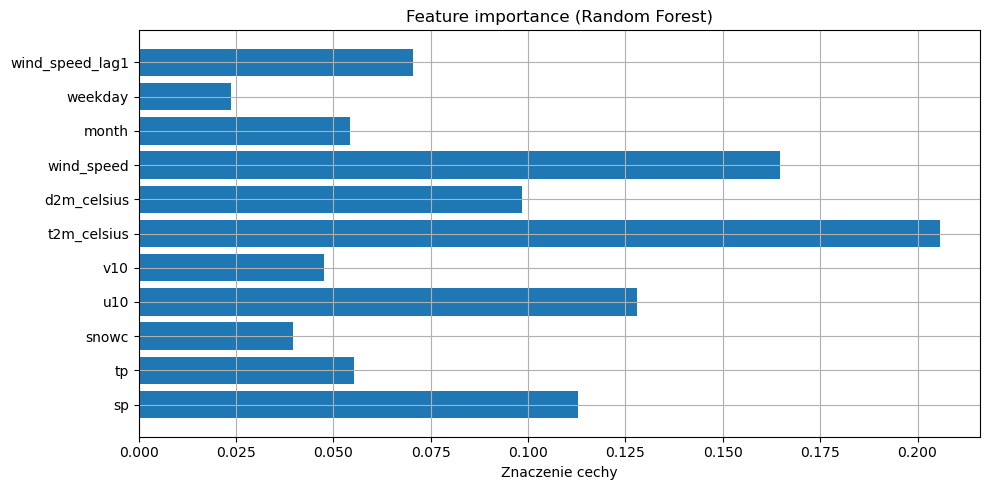

In [22]:
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,5))
plt.barh(feature_names, importances)
plt.xlabel('Znaczenie cechy')
plt.title('Feature importance (Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.show()

We are not going any better, but we are not worse either. Probably we have just to little parameters to predict PM10 concentration accurately.
The model is not able to capture the complexity of the relationship between the weather parameters and PM10 concentration with the current set of features. 
Further feature engineering or using more advanced models might be necessary to improve the predictions.